# **  This notebook handles data processing and loading**

-

-

In [ ]:
from typing import Callable, Any

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import os
import numpy as np
import scipy
from scipy.sparse import csr_matrix
from pathlib import Path
from torch.utils.data import DataLoader
export_dir = os.getcwd()
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import plot
import random
import math
import heapq
from scipy.special import expit  # Sigmoid function
import itertools
from IPython.display import Latex, display
import pickle
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
torch.set_printoptions(sci_mode=False)

test_flag = 1

In [ ]:
pip install ipynb

In [ ]:
from ipynb.fs.defs.utils import *
from ipynb.fs.defs.training import *
from ipynb.fs.defs.models import *

# Load Dataset

In [ ]:
users = pd.read_csv(Path(export_dir,'dataset/ML1M/users.dat'), sep='::', header=None, engine='python').drop(index=4169,axis=0)

movies = pd.read_csv(Path(export_dir,'dataset/ML1M/movies.dat'), sep='::', encoding='ISO-8859-1',header=None, engine='python')
ratings = pd.read_csv(Path(export_dir,'dataset/ML1M/ratings.dat'), sep='::', header=None, engine='python')


In [ ]:
ratings_matrix = ratings.pivot(index=0, columns=1, values=2).fillna(0)
ratings_matrix = (ratings_matrix > 0).astype(int)  # Binarize the ratings
ratings_matrix=ratings_matrix.drop(index=4169)
ratings_matrix=ratings_matrix.reset_index(drop=True)

In [ ]:
# users = pd.read_csv(Path(export_dir,'dataset/movielens/users.dat'), sep='::', encoding='ISO-8859-1',header=None, engine='python')
# users.index = users.loc[:,0]
# users=users.drop(columns=0)

In [ ]:
rel_movies = movies[movies[0].isin(ratings_matrix.columns)]
rel_movies.index = rel_movies[0]
rel_movies = rel_movies.drop(columns=[0])

# Data Processing and analysis:

In [ ]:
indexes_ratings = [index for index in ratings_matrix.columns]

# Create an empty list to store the movie data
movie_names = {}

# Read the .dat file
with open(Path(export_dir,'dataset/ML1M/movies.dat'), 'r', encoding='ISO-8859-1') as file:
    for line in file:
        # Split each line by '::'
        movie_id, movie_name, genres = line.strip().split('::')
        if int(movie_id) in indexes_ratings:
          # Create a dictionary for the current movie with all genres set to 0
          movie_names[movie_id] = movie_name


# Convert the list of dictionaries into a DataFrame
df_movie_names = pd.DataFrame(movie_names.items())
df_movie_names.index= indexes_ratings
df_movie_names = df_movie_names.drop(0, axis=1)
df_movie_names

In [ ]:
# # Define the list of all possible genres
# all_genres = ['Children\'s','Drama', 'Action','Comedy', 'Adventure','Documentary',
#               'Animation', 'Crime','Fantasy','Film-Noir','Mystery', 'Horror',
#               'Musical', 'Romance','Sci-Fi', 'Thriller', 'War', 'Western']

indexes_ratings =  [index for index in ratings_matrix.index]# [index for index in orig_ratings_matrix_index]

# Create an empty list to store the movie data
users_data = []
usr_dict={}

# Read the .dat file
with open(Path(export_dir,'dataset/ML1M/users.dat'), 'r', encoding='ISO-8859-1') as file:
    for line in file:
        # Split each line by '::'

        usr_id, usr_gender, usr_age, usr_occ, usr_zip = line.strip().split('::')
        if int(usr_id) in orig_ratings_matrix_index:
          usr_dict['usr_id'] = int(usr_id)
          usr_dict['gender'] = 1 if usr_gender == 'F' else 0
          usr_dict['age'] = int(usr_age)
          usr_dict['occupation'] = int(usr_occ)
          usr_dict['zip'] = usr_zip
          to_list = usr_dict.copy()
          users_data.append(to_list)


# Convert the list of dictionaries into a DataFrame
df_usr = pd.DataFrame(users_data)
df_usr.index= ratings_matrix.index


In [ ]:
all_genres = ['Children\'s','Drama', 'Action','Comedy', 'Adventure','Documentary',
              'Animation', 'Crime','Fantasy','Film-Noir','Mystery', 'Horror',
              'Musical', 'Romance','Sci-Fi', 'Thriller', 'War', 'Western']
# Create an empty list to store the movie data
movie_data = []

# Read the .dat file
with open(Path(export_dir,'dataset/ML1M/movies.dat'), 'r', encoding='ISO-8859-1') as file:
    for line in file:
        # Split each line by '::'
        movie_id, movie_name, genres = line.strip().split('::')

        # Create a dictionary for the current movie with all genres set to 0
        movie_dict = {genre: 0 for genre in all_genres}
        movie_dict['movie_id'] = int(movie_id)

        # Split the genres and set the corresponding genre keys to 1
        genre_list = genres.split('|')
        for genre in genre_list:
            movie_dict[genre] = 1

        # Append the dictionary to the movie_data list
        movie_data.append(movie_dict)

# Convert the list of dictionaries into a DataFrame
df_movie = pd.DataFrame(movie_data)

# Save the DataFrame to a CSV file
# df_movie.to_csv(Path(export_dir,'movies_data.csv'), index=False)

# what movies belong to a certain genre- lets say children's movies:
genre_id = np.where(df_movie['Children\'s'] == 1)

df_movie.index = df_movie['movie_id']
df_movie

## Hisotgram of number of users VS number of watched movies  

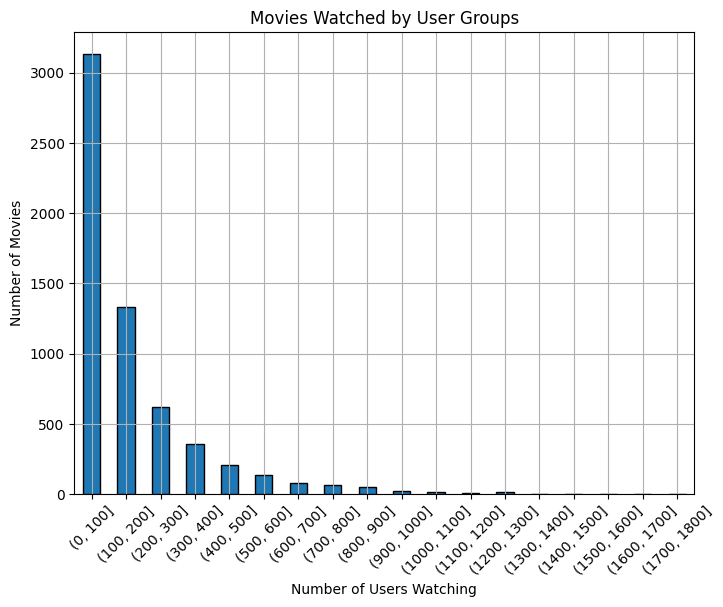

In [ ]:
# calc the number of users (y-axis) that have watched a certain number of movies (x-axis).
num_movies_per_user = ratings_matrix.sum(axis=1)
# max(num_movies_per_user)

plt.figure(figsize=(8, 6))
bins = [i for i in range(0,1900,100)]  # Define bins
binned_users_per_movie = pd.cut(num_movies_per_user, bins=bins).value_counts(sort=False)
binned_users_per_movie.plot(kind='bar', edgecolor='black')
plt.xlabel('Number of Users Watching')
plt.ylabel('Number of Movies')
plt.title('Movies Watched by User Groups')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## graph- dist of 50 popular movies to genres

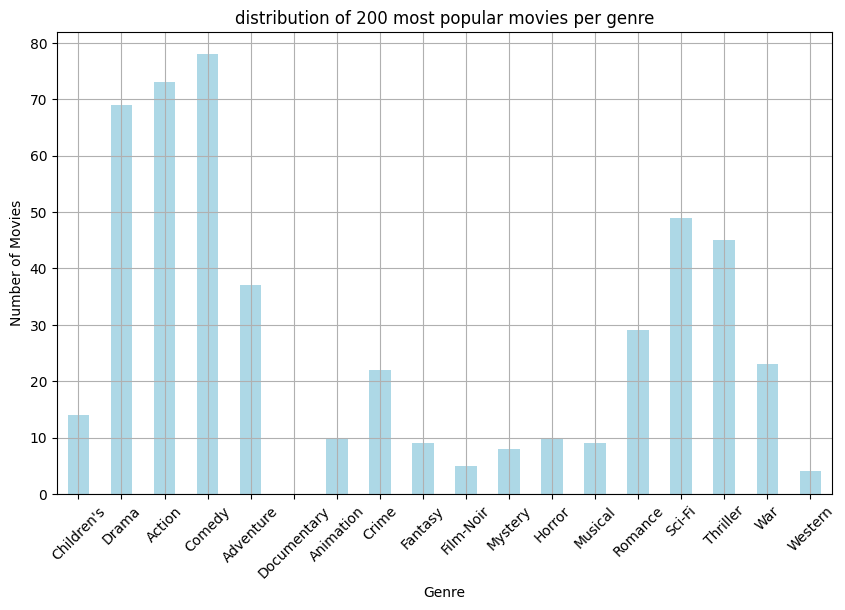

In [ ]:
# who are the popular movies check:
num_users_per_movie = ratings_matrix.sum(axis=0)
num_users_per_movie_sort=num_users_per_movie.sort_values(ascending=False, ignore_index=False)

#ppopular movies:
# most_popular = num_users_per_movie_sort.iloc[0:50]

most_popular = num_users_per_movie_sort.iloc[0:200]
df_movie_popular = df_movie[df_movie['movie_id'].isin(most_popular.index)]
df_movie_popular.index = most_popular.index
df_movie_popular= df_movie_popular.sort_index()


# num of movies for each genre:
num_per_genre = df_movie_popular.sum(axis=0)[0:-1]

plt.figure(figsize=(10,6))
num_per_genre.plot(kind='bar', color='lightblue')
plt.title('distribution of 200 most popular movies per genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## how many  movies are there for each genre:


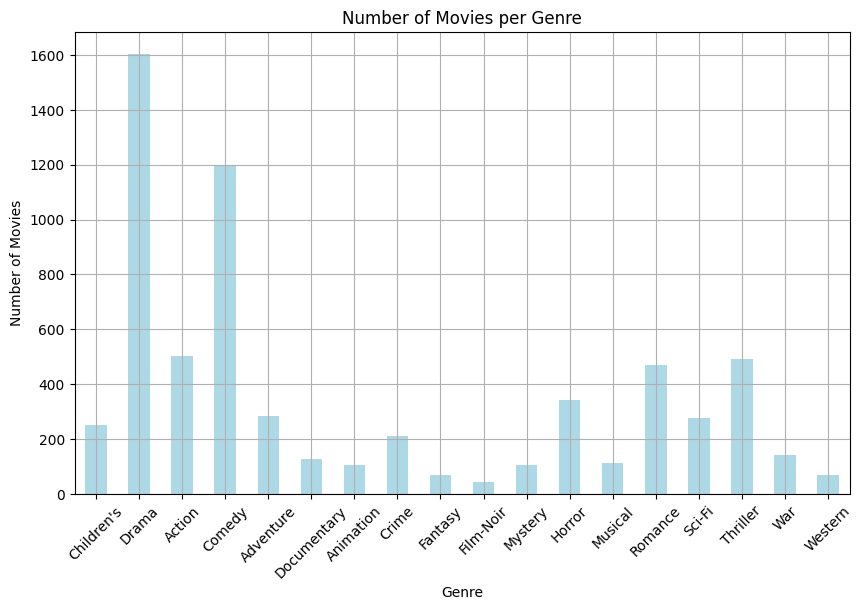

In [ ]:
# num of movies for each genre:
num_per_genre = df_movie.sum(axis=0)[0:-1]

plt.figure(figsize=(10,6))
num_per_genre.plot(kind='bar', color='lightblue')
plt.title('Number of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Filter data into genres

In [ ]:
# from re import U
# # movies of unique genres
# #movies and not index!!!
unique_genre=list(df_movie.index[np.where(df_movie.loc[:,df_movie.columns[0:-2]].sum(axis=1)==1)]) if 'Cluster' in df_movie.columns else list(df_movie.index[np.where(df_movie.loc[:,df_movie.columns[0:-1]].sum(axis=1)==1)])


In [ ]:
# movies of a specific genre
# problem with sci-fi, film-noir, children

genre_children_id = np.array(np.where(df_movie['Children\'s'] == 1)[0])
genre_children_id_name = list(df_movie.index[genre_children_id])

genre_drama_id = np.array(np.where(df_movie['Drama'] == 1)[0])
genre_drama_id_name = list(df_movie.index[genre_drama_id])

genre_action_id = np.array(np.where(df_movie['Action'] == 1)[0])
genre_action_id_name = list(df_movie.index[genre_action_id])

genre_comedy_id = np.array(np.where(df_movie['Comedy'] == 1)[0])
genre_comedy_id_name = list(df_movie.index[genre_comedy_id])

genre_adventure_id = np.array(np.where(df_movie['Adventure'] == 1)[0])
genre_adventure_id_name = list(df_movie.index[genre_adventure_id])

genre_documentary_id = np.array(np.where(df_movie['Documentary'] == 1)[0])
genre_documentary_id_name = list(df_movie.index[genre_documentary_id])

genre_animation_id = np.array(np.where(df_movie['Animation'] == 1)[0])
genre_animation_id_name = list(df_movie.index[genre_animation_id])

genre_crime_id = np.array(np.where(df_movie['Crime'] == 1)[0])
genre_crime_id_name = list(df_movie.index[genre_crime_id])

genre_fantasy_id = np.array(np.where(df_movie['Fantasy'] == 1)[0])
genre_fantasy_id_name = list(df_movie.index[genre_fantasy_id])

genre_filmnoir_id = np.array(np.where(df_movie['Film-Noir'] == 1)[0])
genre_filmnoir_id_name = list(df_movie.index[genre_filmnoir_id])

genre_horror_id = np.array(np.where(df_movie['Horror'] == 1)[0])
genre_horror_id_name = list(df_movie.index[genre_horror_id])

genre_musical_id = np.array(np.where(df_movie['Musical'] == 1)[0])
genre_musical_id_name = list(df_movie.index[genre_musical_id])

genre_mystery_id = np.array(np.where(df_movie['Mystery'] == 1)[0])
genre_mystery_id_name = list(df_movie.index[genre_mystery_id])

genre_romance_id = np.array(np.where(df_movie['Romance'] == 1)[0])
genre_romance_id_name = list(df_movie.index[genre_romance_id])

genre_scifi_id = np.array(np.where(df_movie['Sci-Fi'] == 1)[0])
genre_scifi_id_name = list(df_movie.index[genre_scifi_id])

genre_thriller_id = np.array(np.where(df_movie['Thriller'] == 1)[0])
genre_thriller_id_name = list(df_movie.index[genre_thriller_id])

genre_war_id = np.array(np.where(df_movie['War'] == 1)[0])
genre_war_id_name = list(df_movie.index[genre_war_id])

genre_western_id = np.array(np.where(df_movie['Western'] == 1)[0])
genre_western_id_name = list(df_movie.index[genre_western_id])

genre_id = {}
genre_id['genre_children_id'] = genre_children_id
genre_id['genre_drama_id'] = genre_drama_id
genre_id['genre_action_id'] = genre_action_id
genre_id['genre_comedy_id'] = genre_comedy_id
genre_id['genre_adventure_id'] = genre_adventure_id
genre_id['genre_documentary_id'] = genre_documentary_id
genre_id['genre_animation_id'] = genre_animation_id
genre_id['genre_crime_id'] = genre_crime_id
genre_id['genre_fantasy_id'] = genre_fantasy_id
genre_id['genre_filmnoir_id'] = genre_filmnoir_id
genre_id['genre_mystery_id'] = genre_mystery_id
genre_id['genre_horror_id'] = genre_horror_id
genre_id['genre_musical_id'] = genre_musical_id
genre_id['genre_romance_id'] = genre_romance_id
genre_id['genre_scifi_id'] = genre_scifi_id
genre_id['genre_thriller_id'] = genre_thriller_id
genre_id['genre_war_id'] = genre_war_id
genre_id['genre_western_id'] = genre_western_id

In [ ]:
#items that are children only and nothing else: movies of unique genres
# names!
common_items_children_genre = [item for item in unique_genre if item in genre_children_id_name]
common_items_drama_genre = [item for item in unique_genre if item in genre_drama_id_name]
common_items_action_genre = [item for item in unique_genre if item in genre_action_id_name]
common_items_comedy_genre = [item for item in unique_genre if item in genre_comedy_id_name]
common_items_adventure_genre = [item for item in unique_genre if item in genre_adventure_id_name]
common_items_documentary_genre = [item for item in unique_genre if item in genre_documentary_id_name]
common_items_animation_genre = [item for item in unique_genre if item in genre_animation_id_name]
common_items_crime_genre = [item for item in unique_genre if item in genre_crime_id_name]
common_items_fantasy_genre = [item for item in unique_genre if item in genre_fantasy_id_name]
common_items_filmnoir_genre = [item for item in unique_genre if item in genre_filmnoir_id_name]
common_items_horror_genre = [item for item in unique_genre if item in genre_horror_id_name]
common_items_musical_genre = [item for item in unique_genre if item in genre_musical_id_name]
common_items_mystery_genre = [item for item in unique_genre if item in genre_mystery_id_name]
common_items_romance_genre = [item for item in unique_genre if item in genre_romance_id_name]
common_items_scifi_genre = [item for item in unique_genre if item in genre_scifi_id_name]
common_items_thriller_genre = [item for item in unique_genre if item in genre_thriller_id_name]
common_items_war_genre = [item for item in unique_genre if item in genre_war_id_name]
common_items_western_genre = [item for item in unique_genre if item in genre_western_id_name]

# Dataset visualization

In [ ]:
users_num = df_usr.shape[0]
numerator_gender = [(df_usr.iloc[:,1]).sum(axis=0),users_num-(df_usr.iloc[:,1]).sum(axis=0)]

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
plt.bar(['F', 'M'], numerator_gender, color='mediumblue', width=0.5)
plt.title(f'Gender', pad=20,weight='bold',fontsize=24)
plt.xlabel('gender', labelpad=20,weight='bold',fontsize=20)
plt.ylabel('number of users per gender', labelpad=20,weight='bold',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(True, linestyle='--', alpha=0.5)

print('\n')
print('\n')
print('\n')



numerator_age = []
ages= [1, 18, 25,35,45, 50, 56]
ages_list = ['1','18','25','35','45','50','56']
for age in ages:
  numerator_age_ids = [i for i in np.where(df_usr.iloc[:,2]== age)[0]]
  numerator_age.append(len(numerator_age_ids))

plt.figure(figsize=(10, 6))
r= plt.bar(ages_list, numerator_age, color='mediumblue', width = 0.5)
plt.bar_label(r,fontsize=14)
plt.title(f'Age', pad=20,weight='bold',fontsize=24)
plt.xlabel('ages', labelpad=20,weight='bold',fontsize=20)
plt.ylabel('number of users per age', labelpad=20,weight='bold',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(True, linestyle='--', alpha=0.5)



numerator_occ = []
occs= [i for i in range(21)]
occ_list = ['other','academic/educator','artist','clerical/admin','college/grad student',
            'customer service','doctor/health care','executive/managerial'
            ,'farmer','homemaker','k-12 student','lawyer','programmer','retired',
            'sales/marketing','scientist','self-employed','technician/engineer',
            'tradesman/craftsman','unemployed','writer']
for occ in occs:
  numerator_occ_ids = [i for i in np.where(df_usr.iloc[:,3]== occ)[0]]
  numerator_occ.append(len(numerator_occ_ids))

plt.figure(figsize=(12, 10))
r=plt.barh(occ_list, numerator_occ, color='mediumblue')
plt.bar_label(r,fontsize=14)
plt.title(f'Occupation', pad=20,weight='bold',fontsize=24)
plt.xlabel('number of users per occupation', labelpad=20,weight='bold',fontsize=20)
plt.ylabel('occupation', labelpad=20,weight='bold',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(True, linestyle='--', alpha=0.5)




numerator_zip = []
zips= [i for i in range(10)]
zip_list = ['zone0','zone1','zone2','zone3','zone4','zone5','zone6','zone7','zone8','zone9']
first_dig = [int(df_usr.iloc[i,4][0]) for i in range(df_usr.shape[0])]
for zip in zips:
  numerator_zip_ids = [i for i in np.where(np.array(first_dig) == zip)[0]]
  numerator_zip.append(len(numerator_zip_ids))

plt.figure(figsize=(10,6))
r=plt.bar(zip_list, numerator_zip, color='mediumblue', width=0.5)
plt.bar_label(r,fontsize=14)
plt.title(f'Zip- code', pad=20,weight='bold',fontsize=24)
plt.xlabel('zip code zone', labelpad=20,weight='bold',fontsize=20)
plt.ylabel('number of users per zip code zones', labelpad=20,weight='bold',fontsize=20)
plt.xticks(rotation=90,fontsize=16)
plt.yticks(fontsize=16)


plt.grid(True, linestyle='--', alpha=0.5)

## Load training dataset:



In [ ]:
with open(Path(export_dir,'dataset/ML1M/batch_dataset_MF.pkl'), 'rb') as file:
    dataset_MF = pickle.load(file)

In [ ]:
with open(Path(export_dir,'dataset/ML1M/batch_dataset_NCF.pkl'), 'rb') as file:
    dataset_NCF = pickle.load(file)

In [ ]:
with open(Path(export_dir,'dataset/ML1M/batch_dataset_MF_SAE.pkl'), 'rb') as file:
    dataset_MF_SAE = pickle.load(file)

In [ ]:
with open(Path(export_dir,'dataset/ML1M/batch_dataset_NCF_SAE.pkl'), 'rb') as file:
    dataset_NCF_SAE = pickle.load(file)

# refault item- user recommender embeddings for models initialization

In [ ]:
df_item_mf = pd.read_csv(Path(export_dir,'res_csv/ML1M/mf/items_embeddings_mf_model.csv'))
df_user_mf = pd.read_csv(Path(export_dir,'res_csv/ML1M/mf/users_embeddings_mf_model.csv'))

# CONVERT TO TENSORS
dataset_items_init = torch.tensor(df_item_mf.values, dtype=torch.float32)
dataset_users_init = torch.tensor(df_user_mf.values, dtype=torch.float32)

In [ ]:
df_item_emb = pd.read_csv(Path(export_dir,'res_csv/ML1M/items_embeddings.csv'))
df_user_emb = pd.read_csv(Path(export_dir,'res_csv/ML1M/users_embeddings.csv'))

dataset_item_emb = torch.tensor(df_item_emb.values, dtype=torch.float32)
dataset_user_emb = torch.tensor(df_user_emb.values, dtype=torch.float32)

In [ ]:
# df_user_embeddings = pd.read_csv(Path(export_dir,'NCF_user_embeddings.csv'))
# user_embeddings = torch.tensor(df_user_embeddings.values, dtype=torch.float32)

# df_item_embeddings = pd.read_csv(Path(export_dir,'NCF_item_embeddings.csv'))
# item_embeddings = torch.tensor(df_item_embeddings.values, dtype=torch.float32)

# df_item_emb1 = df_item_embeddings.copy()
# df_item_emb1.index = ratings_matrix.columns

# df_movies = pd.read_csv(Path(export_dir,'csv/movies_data.csv'))  # based on the whole dataset
# df_movies=df_movies.iloc[:,0:-1]
# df_users = pd.read_csv(Path(export_dir,'csv/users_data.csv')) #  based on the whole dataset

# # CONVERT TO TENSORS
# dataset_items = torch.tensor(df_item_emb.values, dtype=torch.float32)
# dataset_users = torch.tensor(df_user_emb.values, dtype=torch.float32)
# movies_data = torch.tensor(df_movies.values, dtype=torch.float32)
# users_data = torch.tensor(df_users.values, dtype=torch.float32)

# Prepare the data for recommenders

In [ ]:
# examples and not indexes
pos_ex = {(row): ratings_matrix.columns[ratings_matrix.iloc[row] == 1].tolist() for row in ratings_matrix.index}
neg_ex = {(row): ratings_matrix.columns[ratings_matrix.iloc[row] == 0].tolist() for row in ratings_matrix.index}
pos_ex_num = {(row): len(pos_ex[row]) for row in ratings_matrix.index}


## for popularity

In [ ]:
popularity= ratings_matrix.sum(axis=0)
dist_pop = [(occur)/(np.array(popularity)).sum() for occur in popularity] # same dist for all users

In [ ]:
# dist_pop_neg_per_user = {}
# for row in ratings_matrix.index:
#   curr_dist_neg = []
#   for i in range(ratings_matrix.shape[1]):
#     if ratings_matrix.columns[i] in neg_ex[row]:
#       curr_dist_neg.append(dist_pop[i])
#   dist_pop_neg_per_user[row]=curr_dist_neg
# # dist_pop_per_user = {(row): [dist_pop[i] for i in range(ratings_matrix.shape[1]) if ratings_matrix.columns[i] in neg_ex[row]] for row in ratings_matrix.index}

# # filtered_probabilities = [dis_pop1[i] for i in range(ratings_matrix.shape[1]) if ratings_matrix.columns[i]] not in pos_ex[0]]

In [ ]:
# dist_pop_pos_per_user = {}
# for row in ratings_matrix.index:
#   curr_dist_pos = []
#   for i in range(ratings_matrix.shape[1]):
#     if ratings_matrix.columns[i] in pos_ex[row]:
#       curr_dist_pos.append(dist_pop[i])
#   dist_pop_pos_per_user[row]=curr_dist_pos

# # with open(Path(export_dir,'dist_pop_pos_per_user.pkl'), 'wb') as file:
# #     pickle.dump(dist_pop_pos_per_user, file)

In [ ]:
with open(Path(export_dir,'dataset/ML1M/dist_pop_neg_per_user.pkl'), 'rb') as file:
    dist_pop_neg_per_user = pickle.load(file)

In [ ]:
with open(Path(export_dir,'datasets/ML1M/dist_pop_pos_per_user.pkl'), 'rb') as file:
    dist_pop_pos_per_user = pickle.load(file)

## infrastructure for sampling of **negative** examples

In [ ]:
# # sample uniformly
# sum_per_user_neg = {key: (np.array(value)).sum() for key, value in dist_pop_neg_per_user.items()}
# norm_prob_neg = {(row): [(dist_pop_neg_per_user[row][i])/sum_per_user_neg[row] for i in range(len(dist_pop_neg_per_user[row]))] for row in ratings_matrix.index}

# sample w.r.t popularity
sum_per_user_neg_exp = {key: np.sum(np.exp(np.array(value))) for key, value in dist_pop_neg_per_user.items()}
norm_prob_neg_exp = {(row): [(np.exp(np.array(dist_pop_neg_per_user[row][i])))/sum_per_user_neg_exp[row] for i in range(len(dist_pop_neg_per_user[row]))] for row in ratings_matrix.index}

## infrastructure for sampling of **positive** examples wrt popularity

In [ ]:
sum_per_user_pos_exp = {key: np.sum(np.exp(np.array(value))) for key, value in
                           dist_pop_pos_per_user.items()}
norm_prob_pos_exp = {(row): [(np.exp(np.array(dist_pop_pos_per_user[row][i])))
                            /sum_per_user_pos_exp[row] for i in
                             range(len(dist_pop_pos_per_user[row]))] for
                            row in ratings_matrix.index}

## Temporal

In [ ]:
# # 5 positive test samples uniformly:
# pos_idx_ex_hidden = {(row): np.sort(np.random.choice(pos_ex[row],replace=False, size=5)) for row in ratings_matrix.index}

# 5 positive test samples using popularity:
pos_idx_ex_hidden = {(row): np.sort(np.random.choice(pos_ex[row], size=5,replace=False, p=norm_prob_pos_exp[row])) for row in ratings_matrix.index}

pos_idx_ex_use = {(row): [item for item in pos_ex[row] if item not in pos_idx_ex_hidden[row]] for row in ratings_matrix.index}

# if there are no neg examples in test set
neg_ex_hidden = []

## model dependant

creates a test set consists of positive and negative examples.

In [ ]:
# sample negative examples to test set:
test_pop_neg = {(row): list(np.random.choice(neg_ex[row],
                       size=5,replace=False, p=norm_prob_neg_exp[row]))
                       for row in ratings_matrix.index}
test_unif_neg = {(row): random.sample(neg_ex[row],5) for row in
                        ratings_matrix.index}

# take test set examples out of all neg examles bank- neg_ex
# wrt popularity
neg_ex_use_pop = {(row): list(filter(lambda x: x not in test_pop_neg[row],
                                neg_ex[row])) for row in ratings_matrix.index}
# uniformly
neg_ex_use_unif = {(row): list(filter(lambda x: x not in test_unif_neg[row],
                                neg_ex[row])) for row in ratings_matrix.index}

neg_ex_hidden = test_pop_neg
neg_ex_use = neg_ex_use_pop

# new train set for popularity: no 10 examples
train_set_pop = {(row): (neg_ex_use[row]+ pos_idx_ex_use[row]) for row in ratings_matrix.index}

In [ ]:
# dist_pop_neg_use_per_user = {}
# for row in ratings_matrix.index:
#   curr_dist_neg_use = []
#   for i in range(ratings_matrix.shape[1]):
#     if ratings_matrix.columns[i] in neg_ex_use[row]:
#       curr_dist_neg_use.append(dist_pop[i])
#   dist_pop_neg_use_per_user[row]=curr_dist_neg_use

# # with open(Path(export_dir,'dist_pop_neg_use_per_user.pkl'), 'wb') as file:
# #     pickle.dump(dist_pop_neg_use_per_user, file)

In [ ]:
with open(Path(export_dir,'dataset/ML1M/dist_pop_neg_use_per_user_0112.pkl'), 'rb') as file:
    dist_pop_neg_use_per_user = pickle.load(file)

In [ ]:
sum_per_user_neg_use_exp = {key: np.sum(np.exp(np.array(value))) for key, value
                        in dist_pop_neg_use_per_user.items()}
norm_prob_neg_use_exp = {(row): [(np.exp(np.array(dist_pop_neg_use_per_user[row][i])))
                            /sum_per_user_neg_use_exp[row] for i in
                             range(len(dist_pop_neg_use_per_user[row]))] for row in
                             ratings_matrix.index}

# "1 hot" matrix

In [ ]:
# for neg examples in test set:
neg_ex_unif = {(row): random.sample(neg_ex_use_unif[row],(pos_ex_num[row]-5)) for row in
            ratings_matrix.index if (pos_ex_num[row]-5)<ratings_matrix.shape[1]/2}
neg_ex_popularity = {(row): list(np.random.choice(neg_ex_use_pop[row],
                      size=len(pos_ex[row]),replace=False, p=norm_prob_neg_use_exp[row]))
                      for row in ratings_matrix.index}

# change wrt unif/pop:
neg_idx_ex_use = neg_ex_popularity


df_1hot = pd.DataFrame(-1, index=ratings_matrix.index, columns=ratings_matrix.columns)
for row in range(ratings_matrix.shwpe[0]):
  df_1hot.loc[row,neg_idx_ex_use[row]]=0
  df_1hot.loc[row,pos_idx_ex_use[row]]=1